<a href="https://colab.research.google.com/github/danielmancovidales/Aplicaciones-en-finanzas/blob/main/Exploratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Librerias generales
import pandas as pd
import numpy as np
import re
from datetime import date
from datetime import datetime
# Librerias e visualización
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Lectura de base de datos filtrado
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
df_filtrado= pd.read_csv('/content/drive/MyDrive/analitica3/Financiera/data_completa.csv')
df_filtrado.drop(['Unnamed: 0'],axis=1, inplace=True)

In [46]:
#Consulta para saber cuántas variables hay por cada tipo
df_filtrado.head(10)

,mes_pago,asegurado_id,reclamacion,diagnostico_codigo,diagnostico_desc,eventos,valor_pagado,mujer,fechanacimiento,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_inicio,fecha_cancelacion,fecha_fin
0,2018-03-01,4834968,examenes de diagnostico,z011,examen de oídos y de la audición,1,4.953413e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
1,2018-04-01,4834968,laboratorio clinico,9,diagnóstico pendiente,15,7.177083e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
2,2018-03-01,4834968,consulta externa,9,diagnóstico pendiente,1,4.278373e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
3,2018-05-01,4834968,examenes de diagnostico,9,diagnóstico pendiente,1,4.969556e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
4,2018-11-01,4834968,consulta externa,9,diagnóstico pendiente,2,5.232234e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
5,2018-10-01,4834968,examenes de diagnostico,i10x,hipertensión esencial (primaria),1,6.849395e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
6,2018-11-01,4834968,examenes de diagnostico,r072,dolor precordial,1,1.134575e+06,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
7,2019-05-01,4834968,consulta externa,9,diagnóstico pendiente,1,4.306256e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
8,2019-01-01,4834968,consulta externa,9,diagnóstico pendiente,1,4.278373e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
9,2018-10-01,4834968,consulta externa,9,diagnóstico pendiente,1,4.351747e+05,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31


**Transformaciones de variables**

In [47]:
#Se cambia la variable mujer por genero donde 1 será genero femenino y 0 será masculino
df_filtrado["genero"] = df_filtrado["mujer"].rename("genero")

#Eliminación
df_filtrado = df_filtrado.drop(["mujer"], axis=1)
df_filtrado.head(2)

,mes_pago,asegurado_id,reclamacion,diagnostico_codigo,diagnostico_desc,eventos,valor_pagado,fechanacimiento,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_inicio,fecha_cancelacion,fecha_fin,genero
0,2018-03-01,4834968,examenes de diagnostico,z011,examen de oídos y de la audición,1,495341.335642,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31,0
1,2018-04-01,4834968,laboratorio clinico,9,diagnóstico pendiente,15,717708.276982,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31,0


In [48]:
#Consulta para saber qué valores tiene la variable genero
df_filtrado["genero"].value_counts()

genero
 1    2391762
 0    1389638
-1         36
Name: count, dtype: int64

In [49]:
#Se eliminan los registros "-1" ya que sólo se tomarán los géneros 1 para F y 0 para M
df_filtrado = df_filtrado.drop(df_filtrado.loc[df_filtrado['genero'] == -1].index)
df_filtrado["genero"].value_counts()

genero
1    2391762
0    1389638
Name: count, dtype: int64

La variable de "fechanacimiento" no aporta datos relevantes al caso de estudio pero nos puede servir para calcular la edad de los afiliados de acuerdo al supuesto de que las bases de datos fueron tomadas alrededor del 2018-2019, por lo tanto se va a calcular como los años transcurridos entre la fecha de nacimiento y la fecha de inicio a la afiliación.

In [55]:
#Convertir la fecha de nacimiento en una variable de edad
df_filtrado['fecha_inicio'] = pd.to_datetime(df_filtrado['fecha_inicio'], format='%Y-%m-%d')
df_filtrado['fechanacimiento'] = pd.to_datetime(df_filtrado['fechanacimiento'], format='%Y-%m-%d')
df_filtrado['edad'] = (df_filtrado['fecha_inicio'] - df_filtrado['fechanacimiento']).dt.days // 365

#Eliminación de las fechas
df_filtrado = df_filtrado.drop(["fecha_inicio", "fechanacimiento"], axis=1)
df_filtrado.head(2)

,mes_pago,asegurado_id,reclamacion,diagnostico_codigo,diagnostico_desc,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_cancelacion,fecha_fin,genero,edad
0,2018-03-01,4834968,examenes de diagnostico,z011,examen de oídos y de la audición,1,495341.335642,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
1,2018-04-01,4834968,laboratorio clinico,9,diagnóstico pendiente,15,717708.276982,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48


In [60]:
#Consulta para saber qué datos tiene la variable diagnostico_codigo
df_filtrado['diagnostico_codigo'].value_counts()

diagnostico_codigo
9       3129154
z017     119923
z108      24590
e039      22271
i10x      12112
         ...   
e507          1
k287          1
g418          1
d52x          1
q45x          1
Name: count, Length: 5823, dtype: int64

No parece tener datos relevantes más que la información del id del diagnóstico por lo que se decide eliminar la variable ya que no aporta datos relevantes al caso de estudio

In [62]:
#Eliminación de la variable
df_filtrado = df_filtrado.drop(["diagnostico_codigo"], axis=1)
df_filtrado.head(2)

,mes_pago,asegurado_id,reclamacion,diagnostico_desc,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_cancelacion,fecha_fin,genero,edad
0,2018-03-01,4834968,examenes de diagnostico,examen de oídos y de la audición,1,495341.335642,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
1,2018-04-01,4834968,laboratorio clinico,diagnóstico pendiente,15,717708.276982,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48


In [64]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3781400 entries, 0 to 3781435
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mes_pago             object 
 1   asegurado_id         int64  
 2   reclamacion          object 
 3   diagnostico_desc     object 
 4   eventos              int64  
 5   valor_pagado         float64
 6   ciudad               object 
 7   cancer               int64  
 8   epoc                 int64  
 9   diabetes             int64  
 10  hipertension         int64  
 11  enf_cardiovascular   int64  
 12  poliza_asegurado_id  int64  
 13  fecha_cancelacion    object 
 14  fecha_fin            object 
 15  genero               int64  
 16  edad                 int64  
dtypes: float64(1), int64(10), object(6)
memory usage: 519.3+ MB


In [65]:
#Consulta para saber cuántas variables hay por cada tipo
df_filtrado.dtypes.value_counts()

int64      10
object      6
float64     1
Name: count, dtype: int64

In [66]:
df_filtrado.isnull().sum()

mes_pago                     0
asegurado_id                 0
reclamacion                  0
diagnostico_desc             0
eventos                      0
valor_pagado                 0
ciudad                      12
cancer                       0
epoc                         0
diabetes                     0
hipertension                 0
enf_cardiovascular           0
poliza_asegurado_id          0
fecha_cancelacion      2176668
fecha_fin                    0
genero                       0
edad                         0
dtype: int64

In [67]:
df_filtrado.shape

(3781400, 17)

In [69]:
#No se sabe aún si la fecha de cancelación es pertinente borrarla o no
df_filtrado["fecha_cancelacion"].value_counts()

fecha_cancelacion
2019-12-31    857160
2018-12-01     28036
2019-07-01     17028
2018-02-01     15117
2019-09-01     14170
               ...  
2018-01-21       114
2018-06-03       111
2018-08-11        99
2018-03-27        86
2018-06-04        85
Name: count, Length: 730, dtype: int64

**Exploración**

In [70]:
#Se consultan las variables numéricas para ver si alguna puede ser considerada como categórica
df_filtrado.select_dtypes(include=['int64'])

,asegurado_id,eventos,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,genero,edad
0,4834968,1,0,0,1,0,0,95576925,0,48
1,4834968,15,0,0,1,0,0,95576925,0,48
2,4834968,1,0,0,1,0,0,95576925,0,48
3,4834968,1,0,0,1,0,0,95576925,0,48
4,4834968,2,0,0,1,0,0,95576925,0,48
...,...,...,...,...,...,...,...,...,...,...
3781431,25333920,1,0,0,0,0,0,189568131,0,30
3781432,17044022,1,0,0,0,0,0,94128351,1,36
3781433,52163564,1,0,0,0,0,0,101267369,1,11
3781434,48242859,1,0,0,0,0,0,175057169,0,15


Las variables asegurado_id, poliza_asegurado_id y edad pueden ser tomadas como categóricas por lo que se cambia su naturaleza a tipo Object

In [71]:
#Cambio a tipo object
df_filtrado[["asegurado_id", "poliza_asegurado_id", "edad"]] = df_filtrado[["asegurado_id", "poliza_asegurado_id", "edad"]].astype(object)

In [72]:
# Se separan las variables categoricas
categoricas= df_filtrado.select_dtypes(include=['object'])

In [73]:
# Se separan las variables numericas
columnas_a_eliminar = df_filtrado.columns.intersection(categoricas.columns)

numericas = df_filtrado.drop(columns=columnas_a_eliminar)

**Numéricas**

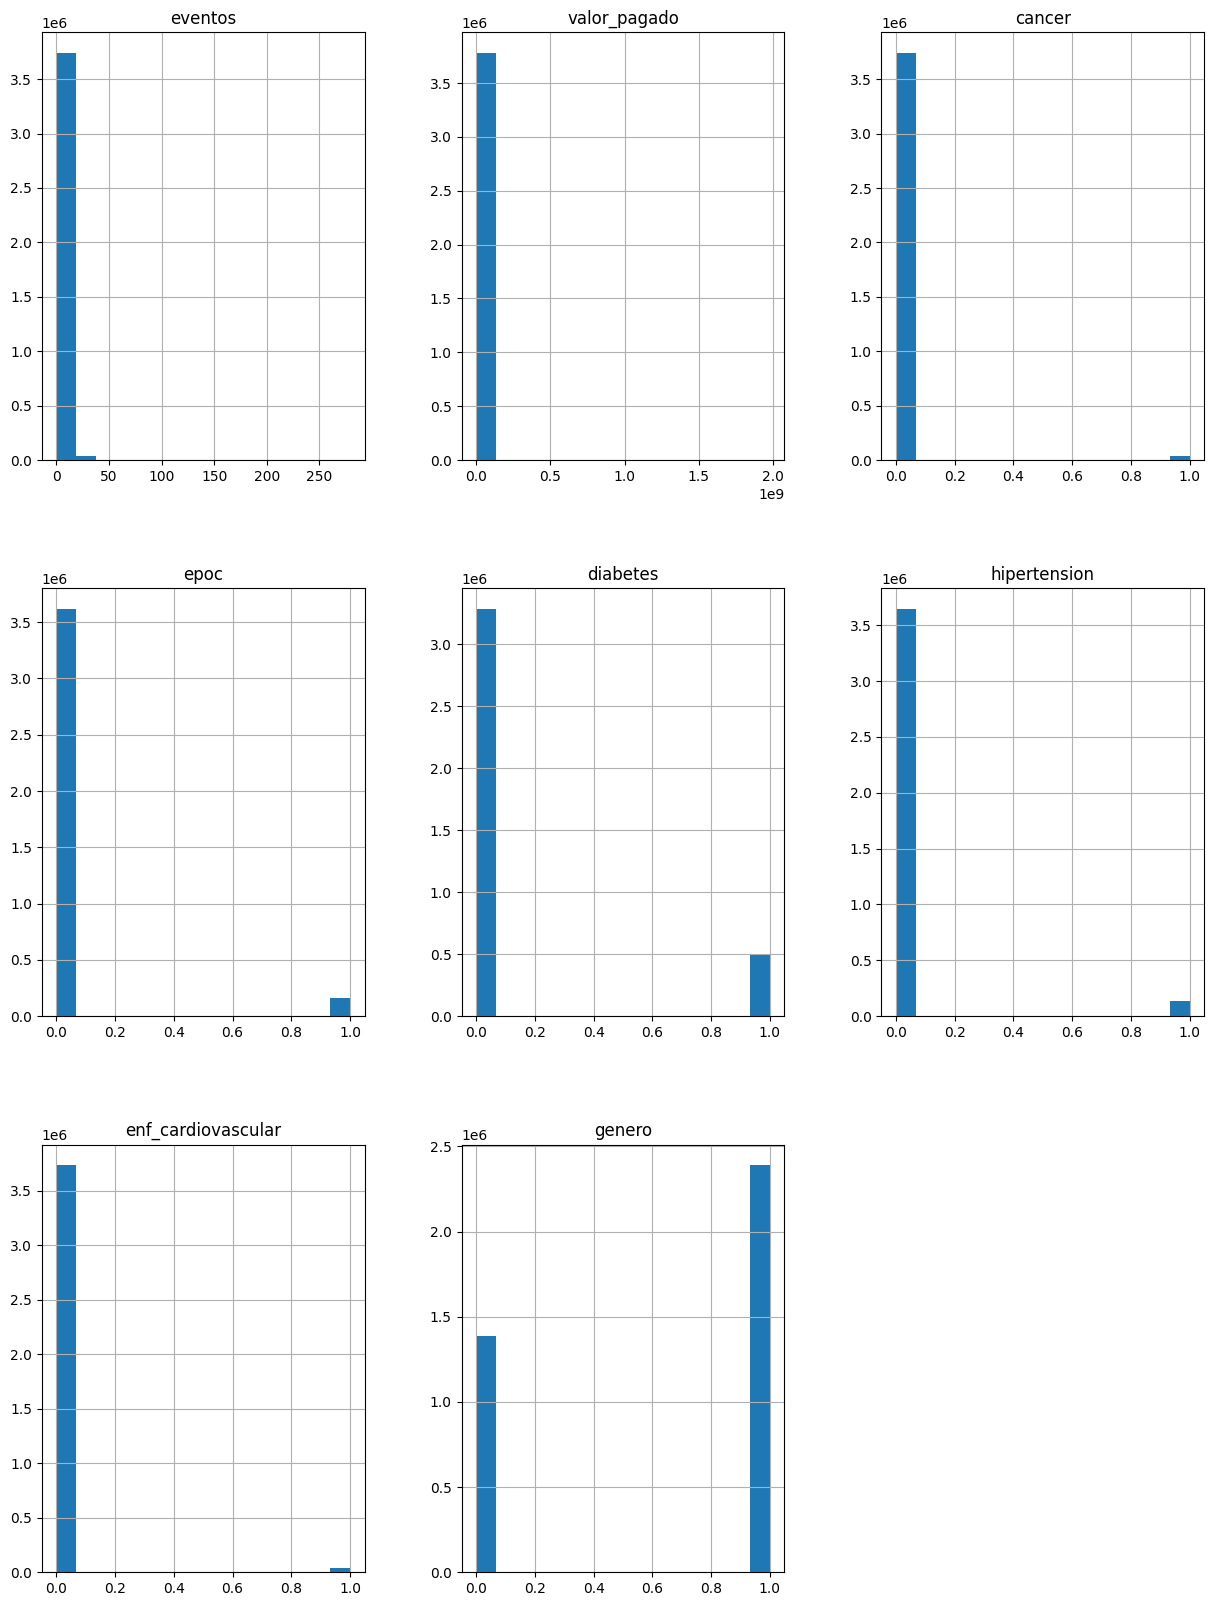

In [75]:
# Se realizan los histogramas para cada variable numérica
%matplotlib inline
numericas.hist(bins=15, figsize=(15, 20))
plt.show()

De las gráficas se puede notar que:

-El número de eventos no es mayor a 35 o 40.

-Un porcentaje muy bajo de los afiliados presentan enfermedades como cáncer, EPOC, enfermedad cardiovascular e hipertensión; la diabetes es la que más se presenta en los afiliados. Sin embargo, el procentaje de afiliados que presentan enfermedades es muy bajo.

-La proporción de mujeres es mayor a la de hombres.

Por el momento se decide no eliminar ninguna variable ya que la cantidad que se tiene de ellas es baja y podría sesgar demasiado los resultados de los modelos posteriores.


**Categóricas**

In [76]:
# Función para diagrama de barras

def plot_category_counts(data, column_name):
    counts = data[column_name].value_counts()
    m = pd.DataFrame({column_name: counts.index, 'Count': counts.values})
    m = m.sort_values(by=column_name)
    sns.barplot(data=m, y=column_name, x='Count')
    plt.show()

In [77]:
#Se crea una base de datos que sólo se va a usar para graficar
categoricas=categoricas.astype(str)

In [80]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3781400 entries, 0 to 3781435
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mes_pago             object 
 1   asegurado_id         object 
 2   reclamacion          object 
 3   diagnostico_desc     object 
 4   eventos              int64  
 5   valor_pagado         float64
 6   ciudad               object 
 7   cancer               int64  
 8   epoc                 int64  
 9   diabetes             int64  
 10  hipertension         int64  
 11  enf_cardiovascular   int64  
 12  poliza_asegurado_id  object 
 13  fecha_cancelacion    object 
 14  fecha_fin            object 
 15  genero               int64  
 16  edad                 object 
dtypes: float64(1), int64(7), object(9)
memory usage: 519.3+ MB


In [81]:
#Se crea una variable que sólo se va a utilizar para graficar las variables categóricas más interesantes
#de acuerdo al criterio del equipo de UdeA Insurance
categoricas_g = df_filtrado[["mes_pago","reclamacion", "diagnostico_desc", "ciudad", "edad"]]

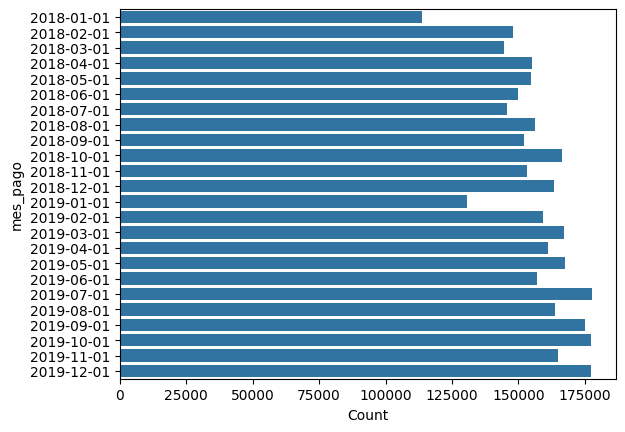

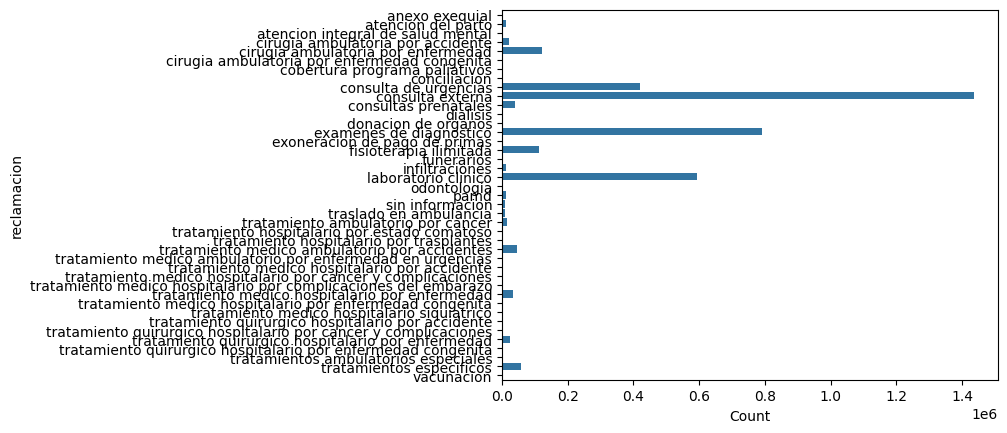

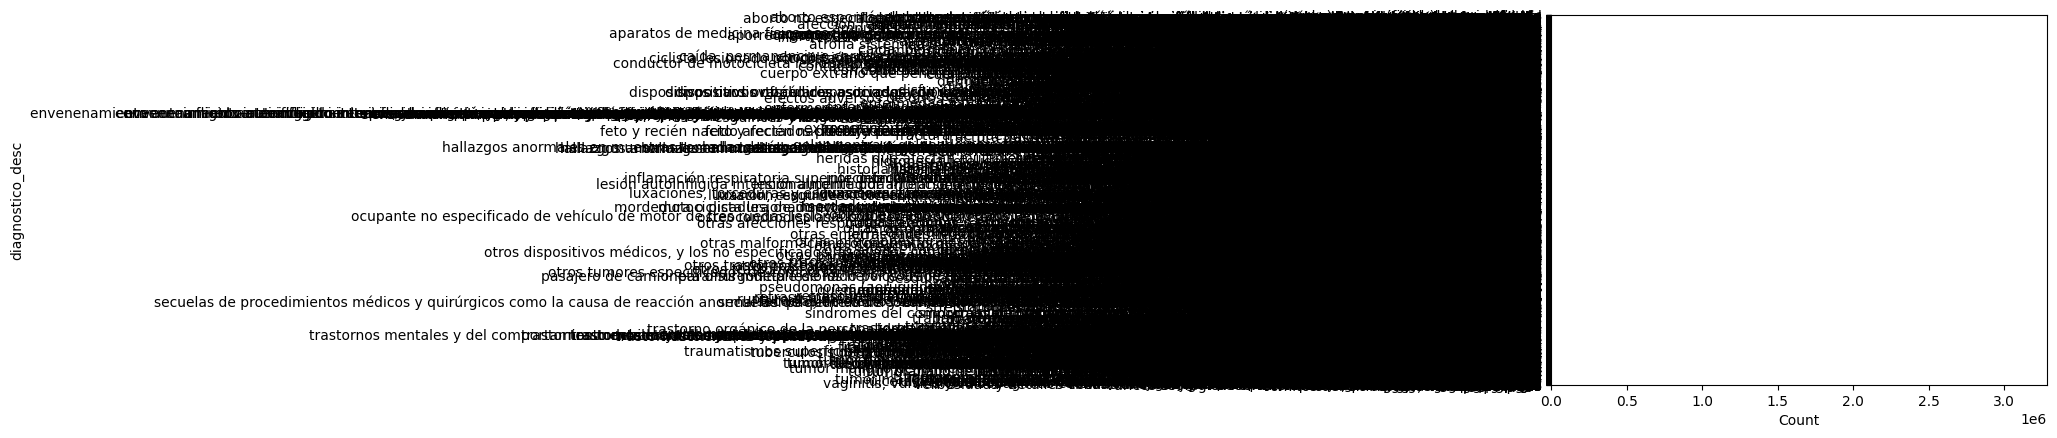

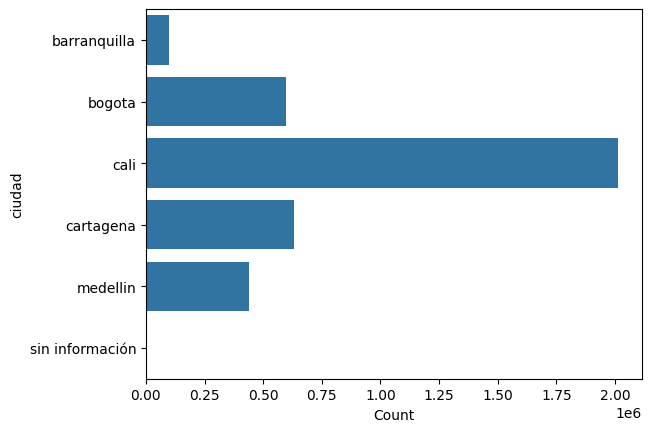

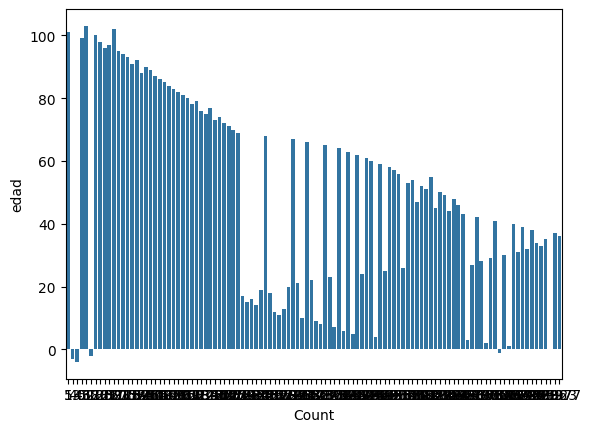

In [82]:
for column in categoricas_g.columns:
    plot_category_counts(categoricas_g, column)

Se puede notar claramente que algunas variables tienen una cantidad de datos diferente que impide analizar su distribución. De las que sí se logra mostrar sus valores se identifica que:

-La consulta externa, exámenes de diagnóstico, laboratorio clínico y consulta de urgencias son las reclamaciones más comunes.

-Cali es la ciudad que más afiliado tiene seguida de Cartagena y Bogotá en medidas muy parecidas y siendo Medellín y Barranquilla las de menor número de afiliados.